# Support Vector Machines

Course: Machine Learning II, Data Science Master (Universidad de Cantabria - UIMP).  
Author: Steven Van Vaerenbergh.

## Introduction

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm

# inline plots
%matplotlib inline

# Part 1: Motivation

Support Vector Machines (SVMs) are a powerful supervised learning algorithm used for **classification** or for **regression**. SVMs are a **discriminative** classifier: that is, they draw a boundary between clusters of data.

Let's show a quick example of support vector classification. First we need to create a dataset:

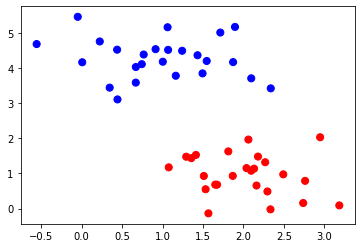

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

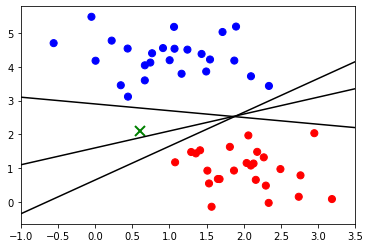

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
plt.plot([0.6], [2.1], 'x', color='green', markeredgewidth=2, markersize=10)

# plot dividing lines
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

# set x limits
plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!

Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.

Here is an example of how this might look:

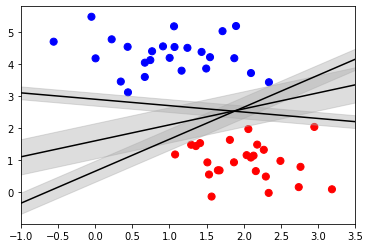

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')

# plot divigind lines and margins (pre-calculated)
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

# set x limits
plt.xlim(-1, 3.5);

Notice here that if we want to maximize this width, the middle fit is clearly the best.

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

This is the intuition of **support vector machines**, which optimize a linear discriminant model in conjunction with a **margin** representing the perpendicular distance between the datasets.

### Fitting a Support Vector Machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the penalty parameter ``C`` to a very large number (which corresponds to a very low regularization).

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
clf = SVC(kernel='linear', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

To better visualize what's happening here, let us create a quick convenience function that will plot SVM decision boundaries for us:

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 50)
    y = np.linspace(ylim[0], ylim[1], 50)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none',
                   edgecolor='black')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

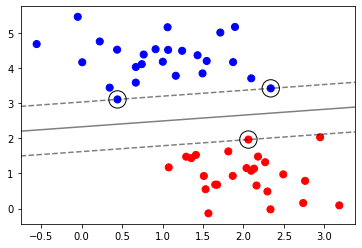

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
plot_svc_decision_function(clf)

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [8]:
clf.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 50 points and first 100 points of this dataset:

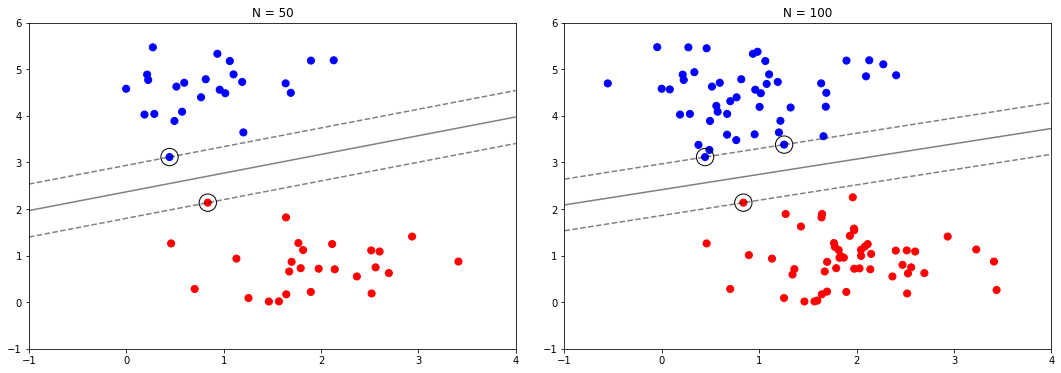

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E6)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [50, 100]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

What othervariables have been calculated by the SVM?
Let's have a look at the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [10]:
print("Indices of support vectors: {}\n".format(clf.support_))

print("Number of support vectors for each class: {}\n".format(clf.n_support_))

print("Coefficients of the support vector in the decision function: {}\n".format(clf.dual_coef_))

print("Weights assigned to the features (linear SVM only).: {}\n".format(clf.coef_))

print("Constants in decision function: {}\n".format(clf.intercept_))

Indices of support vectors: [18 25  7]

Number of support vectors for each class: [2 1]

Coefficients of the support vector in the decision function: [[-0.2738502  -0.75147416  1.02532437]]

Weights assigned to the features (linear SVM only).: [[ 0.23525694 -1.41250783]]

Constants in decision function: [3.29634152]



# Part 2: Nonlinear SVM using Kernels

Where SVM becomes extremely powerful is when it is combined with *kernels*.
By using kernels we will project our data into higher-dimensional space defined by polynomial, Gaussian or other basis functions, and thereby we will be able to fit for nonlinear relationships with a linear classifier.

To motivate the need for kernels, let's look at some data that is not linearly separable:

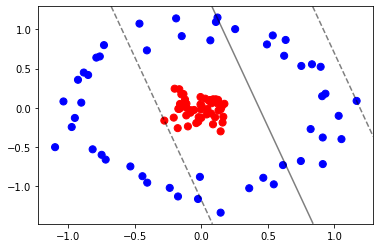

In [11]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1, random_state=0)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
plot_svc_decision_function(clf, plot_support=False)

It is clear that no linear discrimination will *ever* be able to separate this data.
But, we could project the data into a higher dimension such that a linear separator *would* be sufficient.

For example, we could define the simple polynomial mapping $\Phi(x) = \begin{bmatrix}x_1^2\\x_2^2\\\sqrt{2}x_1x_2\end{bmatrix}$ and apply the support vector machine on $\Phi(x)$.

In [12]:
# Construct the polynomial mapping. [:,None] is usd to convert 1D array to 2D array.
Phi = np.concatenate((X**2, np.sqrt(2)*(X[:,0]*X[:,1])[:,None]), axis=1)

We can visualize this extra data dimension using a three-dimensional plot:

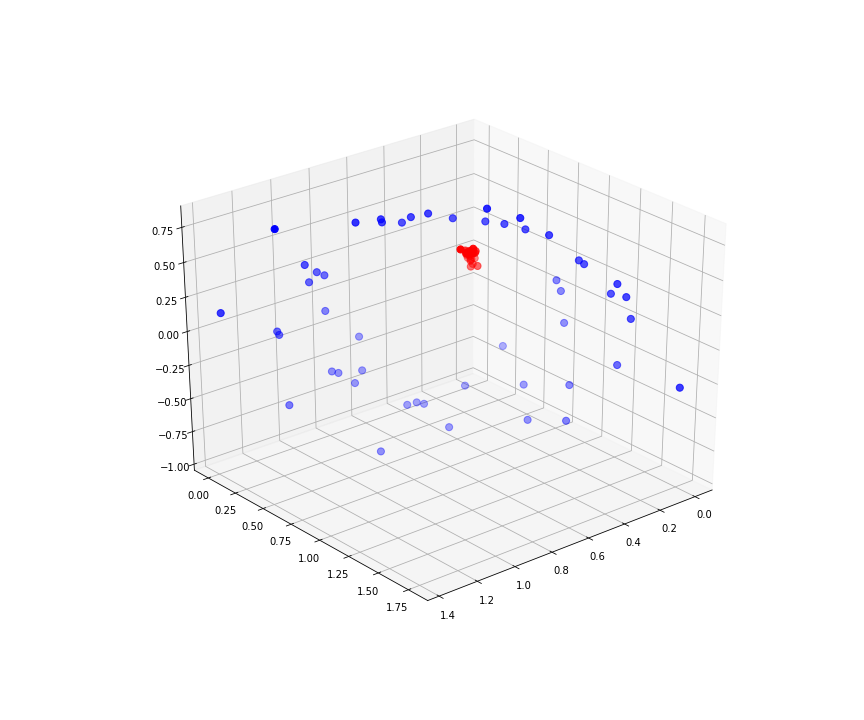

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# bug fix for matplotlib 3.0.0
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

# retrieve indices of zeroes and ones
idx0 = y==0
idx1 = y==1

# initialize the viewing angles
ax.view_init(30, 50)

# plot the data
ax.scatter(Phi[idx0,0], Phi[idx0,1], Phi[idx0,2], c='b', marker='o', s=50)
ax.scatter(Phi[idx1,0], Phi[idx1,1], Phi[idx1,2], c='r', marker='o', s=50)

plt.show()

Let us generate an interactive plot to inspect the data more closely.
We will use the Plotly library: https://plot.ly/

In [14]:
# load Plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go

# initiate the Plotly Notebook mode
init_notebook_mode(connected=True)

In [15]:
# define a function for 3D plotting using Plotly
def plot_3D(X, y):
    
    # retrieve indices of zeroes and ones
    idx0 = y==0
    idx1 = y==1
    
    # define data set 1 plot options
    trace0 = go.Scatter3d(x=X[idx0,0], y=X[idx0,1], z=X[idx0,2],
        mode='markers',
        marker=dict(size=6, color='blue', opacity=0.8)
    )

    # define data set 2 plot options
    trace1 = go.Scatter3d(x=X[idx1,0], y=X[idx1,1], z=X[idx1,2],
        mode='markers',
        marker=dict(size=6, color='red', opacity=0.8)
    )

    # set aspect ratio
    scene = dict(aspectmode="manual", aspectratio=dict(x=1, y=1, z=1))

    # define figure properties
    layout = go.Layout(
        scene=scene,
        height=600,
        width=900
    )

    # produce the plot
    fig = go.Figure(data=[trace0,trace1],layout=layout)
    iplot(fig)

In [17]:
# plot the data
plot_3D(Phi,y)

Another simple projection could be to simply add a *radial basis function* centered on the origin (where the red cluster resides): $\Phi(x) = \begin{bmatrix}x_1\\x_2\\\exp\left(-\left\|\begin{bmatrix}x_1\\x_2\end{bmatrix}\right\|^2)\right)\end{bmatrix}$

In [18]:
# Construct the mapping.
Phi = np.concatenate((X*X, np.exp(-(X ** 2).sum(1))[:,None]), axis=1)

# plot
plot_3D(Phi,y)

In both cases, we can see that with the additional dimension the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7 in the last example.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [19]:
clf = SVC(kernel='rbf', C=1E6, gamma='auto')
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

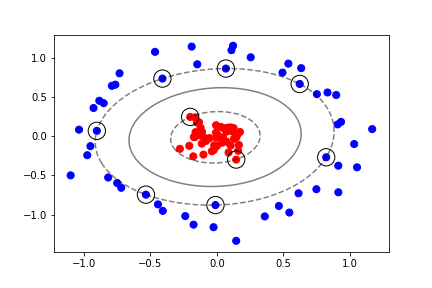

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

Let's visualize the SVM model for different numbers of data:

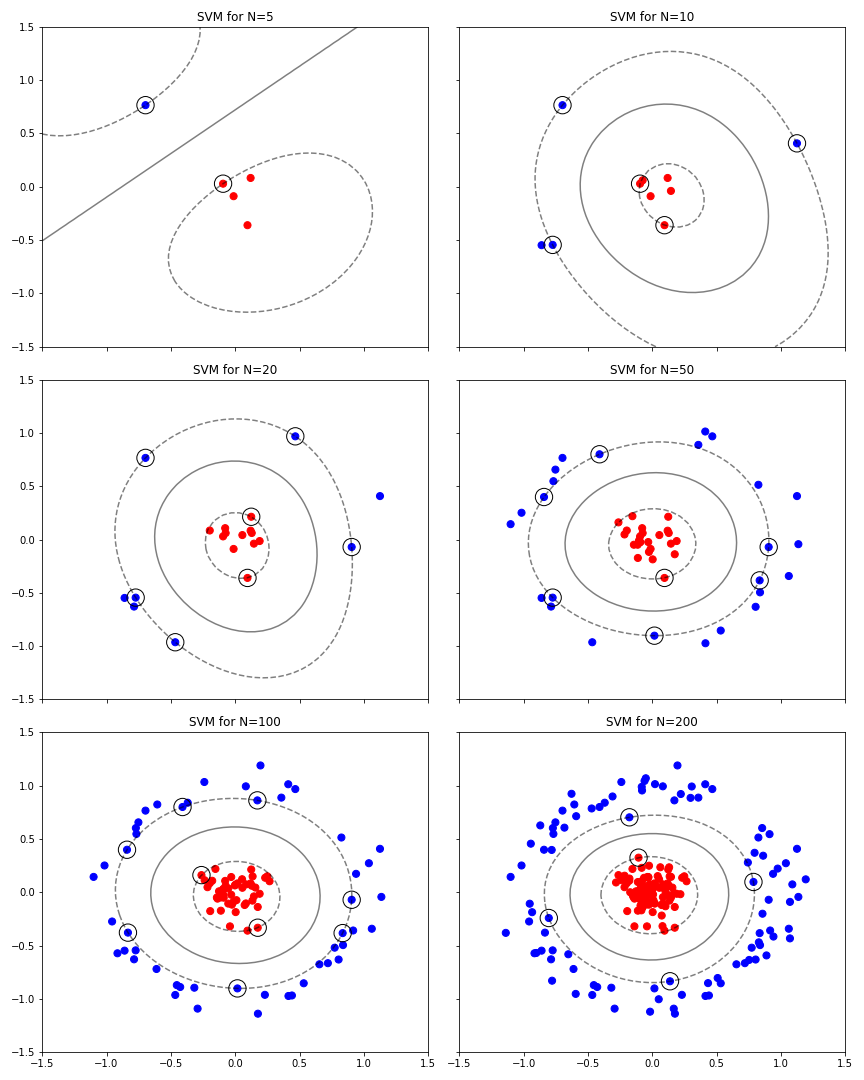

In [21]:
def plot_svm_circles(N=5, ax=None):
    X, y = make_circles(500, factor=.1, noise=.1, random_state=0)

    X = X[:N]
    y = y[:N]
    model = SVC(kernel='rbf', C=1E6, gamma='auto')
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    plot_svc_decision_function(model, ax)

# initialize figure with subplots
fig, ax = plt.subplots(3, 2, figsize=(12, 15),sharex=True,sharey=True)
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, N in zip(np.ravel(ax), [5, 10, 20, 50, 100, 200]):
    
    # generate data (same every loop)
    X, y = make_circles(500, factor=.1, noise=.1, random_state=0)

    # select data and train SVM
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='rbf', C=1E6, gamma='auto')
    model.fit(X, y)
    
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
    axi.set_xlim(-1.5, 1.5)
    axi.set_ylim(-1.5, 1.5)
    plot_svc_decision_function(model, axi)
    axi.set_title('SVM for N=%d'%N)

plt.tight_layout()
plt.show()

# Part 3: Tuning the SVM

## 3.1 Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

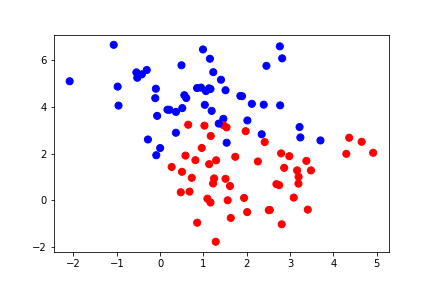

In [22]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

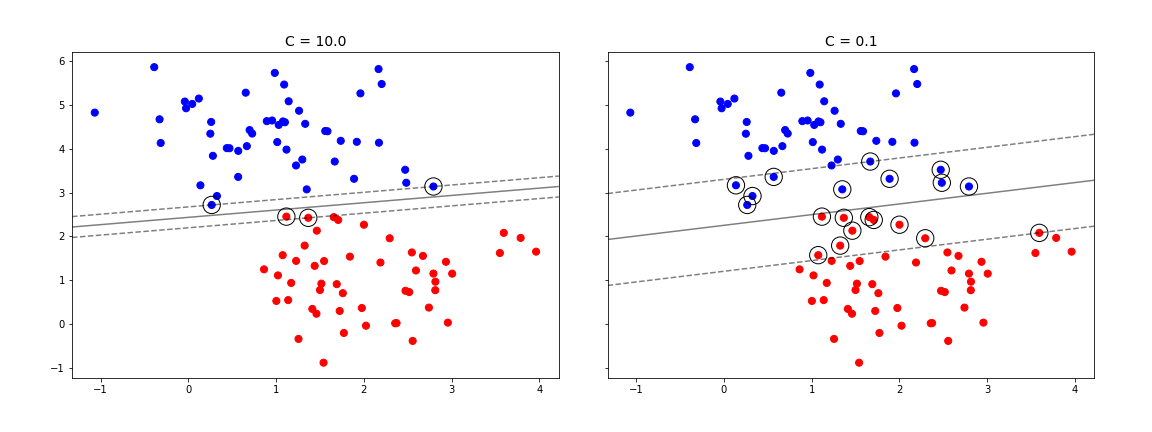

In [23]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

# initialize figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6),sharey=True)
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    # train SVM
    model = SVC(kernel='linear', C=C).fit(X, y)
    
    # plot results    
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none')
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure.

### 3.2 The RBF kernel parameter $\gamma$

The RBF (or *Gaussian*) kernel is defined as $k(x, x') = e^{- \gamma \Vert x - x' \Vert^2}$, where is expressed in terms of the Gaussian kernel width $\sigma$ as $\gamma = \frac{1}{2 \sigma^2}$. The parameter $\gamma$ controls the smoothness of the decision boundary. In the following interactive example we will study the influence of both the parameter $\gamma$ and the parameter $C$.

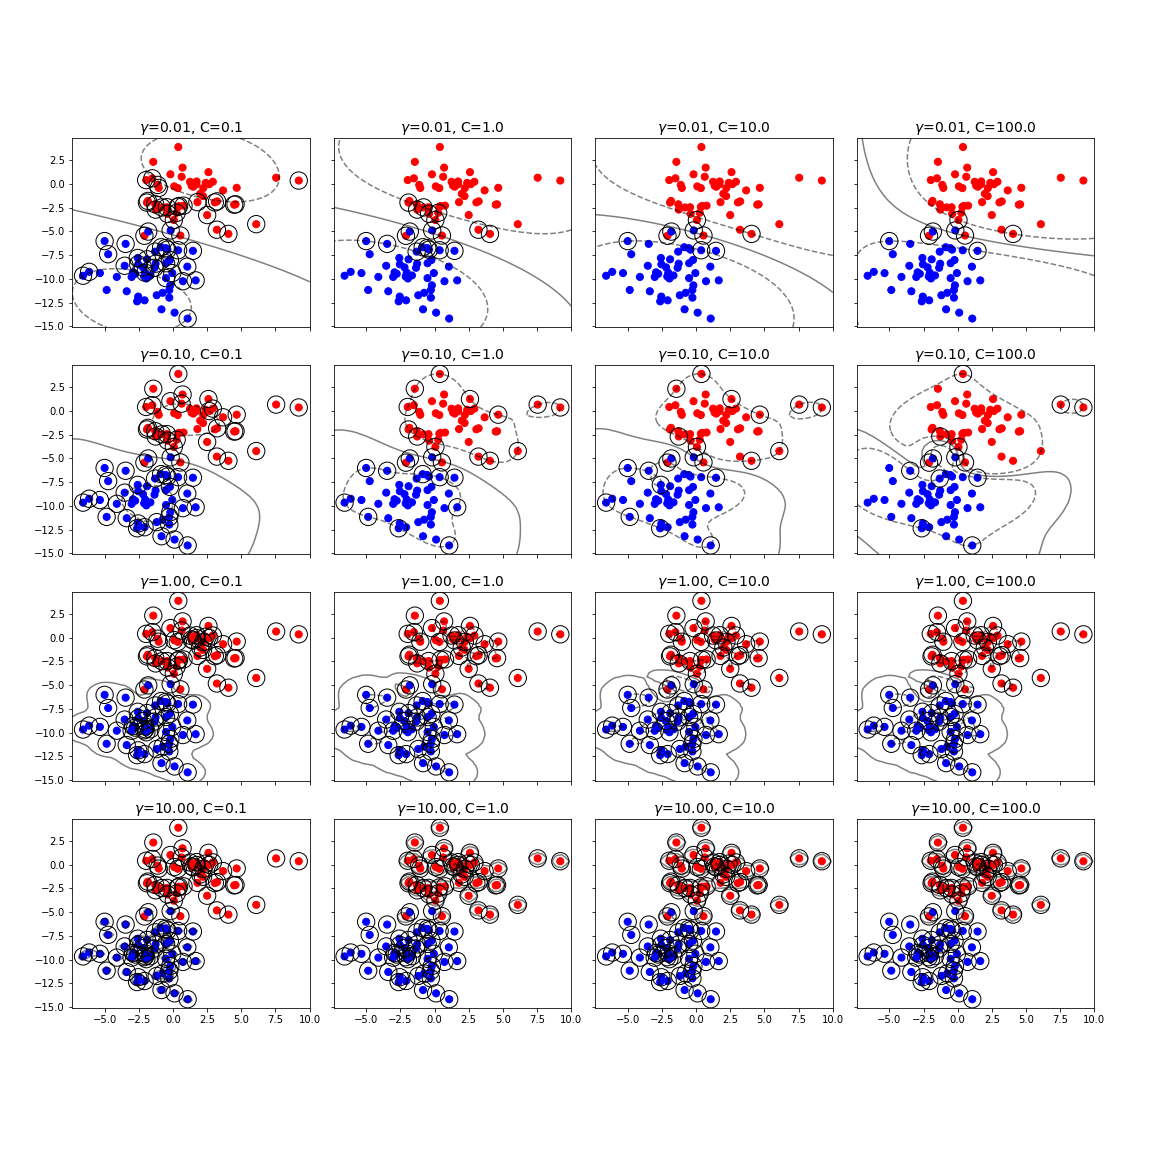

In [24]:
def plot_svm_circles(gamma=.1, C=10, ax=None):
    X, y = make_blobs(n_samples=100, centers=2,
                  random_state=2, cluster_std=2)

    model = SVC(kernel='rbf',gamma=gamma, C=C)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
    plot_svc_decision_function(model, ax, plot_support=True)

# define parameters
gamma_values = [0.01,0.1,1,10] # gamma alto -> flexibilidad
C_values = [0.1,1,10,100] # gamma alto -> restriccion

# initialize figure with subplots
fig, ax = plt.subplots(len(gamma_values), len(C_values), figsize=(16, 16),
                       sharex=True, sharey=True)
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# all possible pairs of gammas and Cs
parameters = np.array(np.meshgrid(gamma_values,C_values)).T.reshape(-1,2)

for axi, gammaC in zip(np.ravel(ax), parameters):
    gamma = gammaC[0]
    C = gammaC[1]
    
    plot_svm_circles(gamma,C,ax=axi)
    axi.set_title('$\gamma$=%.2f, C=%.1f'%(gamma,C), size=14)


# Part 4: Examples with real data

## Example: Iris Dataset
As an example of support vector machines in action, let's take a look at the iris data classification problem. While these data have 4 dimensions and 3 classes, we will use a subset of the data that uses only the first two dimensions and the last two classes.

In [25]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

# remove class 0 and select the first 2 dimensions
X = X[y != 0, :2]
y = y[y != 0]

print('Size of X is: '+str(X.shape))

Size of X is: (100, 2)


We will train the classifier on one subset of the data, called the *training* data, and we will withold a separate subset called the *test* data to test or validate the classifier's performance.

Splitting the data into training and test set could be done "manually" as follows:

In [26]:
# fraction of the data to assign to the test set
test_size = 0.2

n_sample = len(X)

# randomly permute the data
np.random.seed(0)
order = np.random.permutation(n_sample)
X_permutated = X[order]
y_permutated = y[order].astype(np.float)

X_train = X_permutated[int(test_size * n_sample):]
y_train = y_permutated[int(test_size * n_sample):]
X_test = X_permutated[:int(test_size * n_sample)]
y_test = y_permutated[:int(test_size * n_sample)]

print('Size of X_train is: '+str(X_train.shape))
print('Size of X_test is: '+str(X_test.shape))

Size of X_train is: (80, 2)
Size of X_test is: (20, 2)


Or, we could do all of this in one line using scikit-learn's built-in function `train_test_split`:

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=0)

print('Size of X_train is: '+str(X_train.shape))
print('Size of X_test is: '+str(X_test.shape))

Size of X_train is: (80, 2)
Size of X_test is: (20, 2)


### Comparison of SVM kernels on Iris

Accuracy for linear: 0.75
Accuracy for rbf: 0.7
Accuracy for poly: 0.7


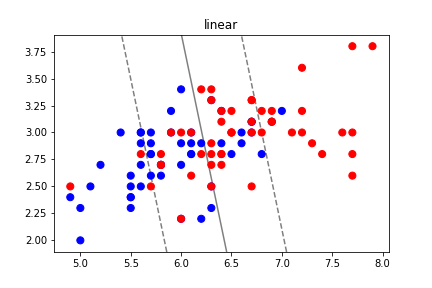

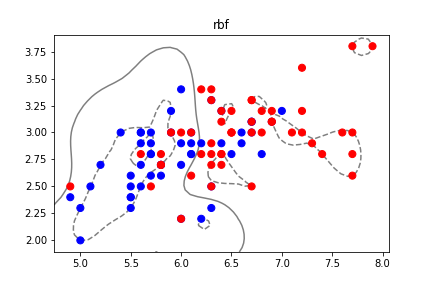

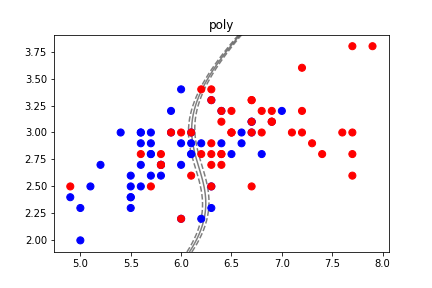

In [28]:
from sklearn.metrics import accuracy_score

kernels = ('linear', 'rbf', 'poly')

# fit the model
for fig_num, kernel in enumerate(('linear', 'rbf', 'poly')):
    clf = svm.SVC(kernel=kernel, gamma=10)
    clf.fit(X_train, y_train)

    plt.figure(fig_num)
    plt.clf()
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap='bwr', s=50)

    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    
    plot_svc_decision_function(clf, plot_support=False)

    # evaluation
    y_pred = clf.predict(X_test)
    
    print('Accuracy for '+kernel+': '+str(accuracy_score(y_test, y_pred)))
    
    plt.title(kernel)
plt.show()

## Exercise: Iris Dataset

Apply an SVM classifier on the complete 4-dimensional Iris data set (2 classes only).

1. Construct the data. Choose a training size of 70% of the data.
2. Choose a kernel and run the SVM classifier on the training data.
3. Calculate the evaluation accuracy on the test data. Adjust the kernel parameters to maximize the accuracy.
4. [Bonus] Make a 3D plot of the results. Use a 3D scatter plot to draw the data, and indicate misclassified test data with crosses.

In [30]:
# 1. Data
iris = datasets.load_iris()
X = iris.data
y = iris.target

# remove class 0 and select the first 2 dimensions
X = X[y != 0,:]
y = y[y != 0]

print('Size of X is: '+str(X.shape))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state = 0)

print('Size of X_train is: '+str(X_train.shape))
print('Size of X_test is: '+str(X_test.shape))

Size of X is: (100, 4)
Size of X_train is: (70, 4)
Size of X_test is: (30, 4)


In [49]:
# 2. SVM
clf = svm.SVC(kernel = 'poly', gamma = 10,C = 1000)
clf.fit(X_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [50]:
# 3. Evaluate
y_pred = clf.predict(X_test)
print('Accuracy for rbf: '+str(accuracy_score(y_test, y_pred)))

Accuracy for rbf: 0.9333333333333333


In [ ]:
# 4. [Bonus] 3D plot

## Example: Spam detection

In this example our goal is to use an SVM to build a spam filter. Here is a sample of a legitimate email:

````
> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com
````

And here is a sample of a spam email:

````
Do You Want To Make $1000 Or More Per Week?

If you are a motivated and qualified individual - I 
will personally demonstrate to you a system that will 
make you $1,000 per week or more! This is NOT mlm.

Call our 24 hour pre-recorded number to get the 
details.  

000-456-789
````

The trained SVM must be capable of predicting whether or not a new email is spam. Before training the SVM, however, the text input must be preprocessed so that we can calculate a meaningful kernel. Preprocessing usually consists in cleanup tasks such as HTML removal, stemming, normalization. Then, a dictionary is constructured for all words that should be considered. Finally, the text of each email is mapped to a vector whose length is the number of dictionary words, and the i-th entry in this vector is a boolean indicating if the i-th dictionary word appears in the email. These vectors are called *word occurance vectors*.

In order to focus on the machine learning task we use pre-processed training and test data to train the classifier. These sets contain the spam and non-spam emails transformed to word occurance vectors.

In [51]:
from scipy.io import loadmat

spam_train = loadmat('data/spamTrain.mat')
spam_test = loadmat('data/spamTest.mat')

spam_train

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Nov 13 14:27:25 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'y': array([[1],
        [1],
        [0],
        ...,
        [1],
        [0],
        [0]], dtype=uint8)}

In [52]:
X_train = spam_train['X']
X_test = spam_test['Xtest']
y_train = spam_train['y'].ravel()
y_test = spam_test['ytest'].ravel()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4000, 1899), (4000,), (1000, 1899), (1000,))

Each document has been converted to a vector with 1,899 dimensions corresponding to the 1,899 words in the dictionary. The values are binary, indicating the presence or absence of the word in the document. At this point, training and evaluation are just a matter of fitting the testing the classifer.

In [53]:
svc = svm.SVC(kernel='rbf',gamma='auto')
svc.fit(X_train, y_train)
print('Training accuracy = {0}%'.format(np.round(svc.score(X_train, y_train) * 100, 2)))

Training accuracy = 94.4%


In [54]:
print('Test accuracy = {0}%'.format(np.round(svc.score(X_test, y_test) * 100, 2)))

Test accuracy = 95.3%


These result were obtained with the default parameters. Go ahead and change the kernel parameters in order to increase the test accuracy.

## Example: Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [55]:
#!/usr/bin/env python -W ignore::DeprecationWarning
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let us analyze the dimensions of the input data:

In [56]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = faces.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
n_features = faces.data.shape[1]

# the label to predict is the id of the person
y = faces.target
target_names = faces.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1348
n_features: 2914
n_classes: 8


Let's plot a few of these faces to see what we're working with:

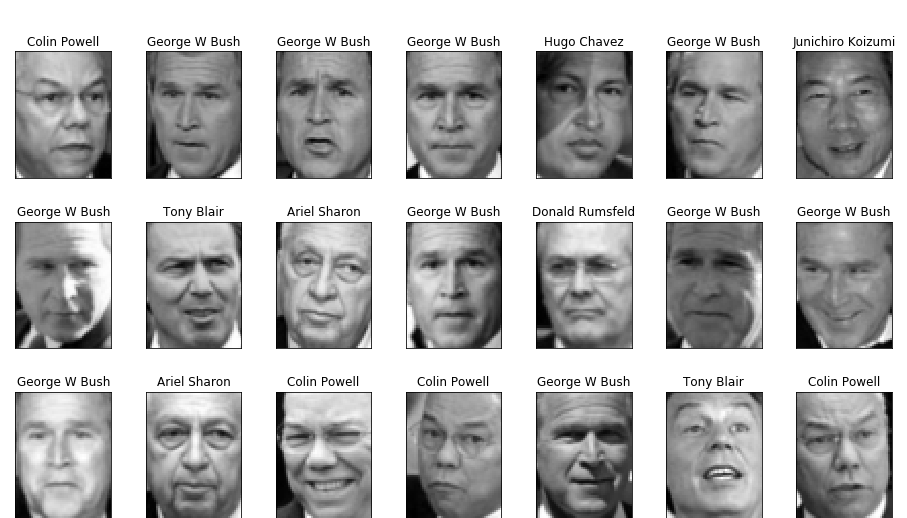

In [57]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=7):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(faces.data, faces.target_names[faces.target], h, w)

We will split the data into a training and testing set:

In [58]:
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target,
                                                    random_state=0)

Each image contains [62×47] or nearly 2914 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis to extract 150 principal components to feed into our support vector machine classifier.

In [59]:
from sklearn.decomposition import PCA

# PCA with whitening, which will remove the relative variance
# scales of the components
n_components = 150
pca = PCA(n_components=n_components, whiten=True,
          svd_solver='randomized', random_state=0)

# Calculata and apply PCA
X_train_pca = pca.fit_transform(X_train)

# Check the percentage of the variance explained by the PCs
var_explained = pca.explained_variance_ratio_.cumsum()[n_components-1]
print("Variance explained by the first %d components: %.2f"%(n_components,var_explained))

Variance explained by the first 150 components: 0.95


Let us have a look at the eigenfaces:

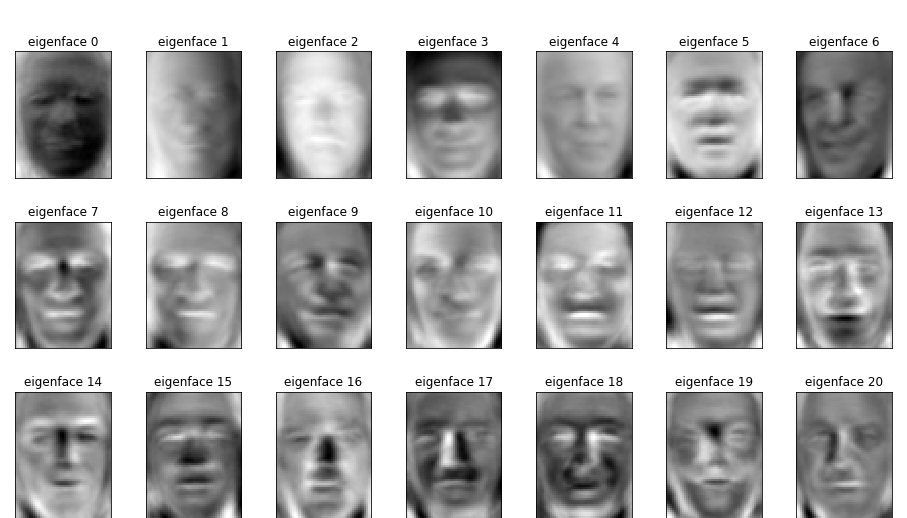

In [60]:
# Calculate the principal directions, called the "eigenfaces"
eigenfaces = pca.components_.reshape((n_components, h, w))

# Plot the gallery of the most significant eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

Now we will train the SVM classifier. In order to determine the best parameters $C$ and $\gamma$ for our SVM we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [61]:
from sklearn.model_selection import GridSearchCV
from time import time

t0 = time()
print("Fitting the classifier to the training set...")
param_grid = {'C': [1E2, 5E2, 1E3, 5E3, 1E4],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=3)
grid.fit(X_train_pca, y_train)
clf = grid.best_estimator_

print("Elapsed time: %0.3fs"%(time() - t0))
print("Best estimator found by grid search:")
print(grid.best_params_)

Fitting the classifier to the training set...
Elapsed time: 46.422s
Best estimator found by grid search:
{'C': 100.0, 'gamma': 0.005}


Finally, we can test our SVM classifier on the test data.

In [62]:
print("Predicting people's names on the test set...")

# apply the same PCA transform as before
X_test_pca = pca.transform(X_test)
y_pred = clf.predict(X_test_pca)

print("Done.")

Predicting people's names on the test set...
Done.


Let us take a look at a few of the test images along with their predicted values:

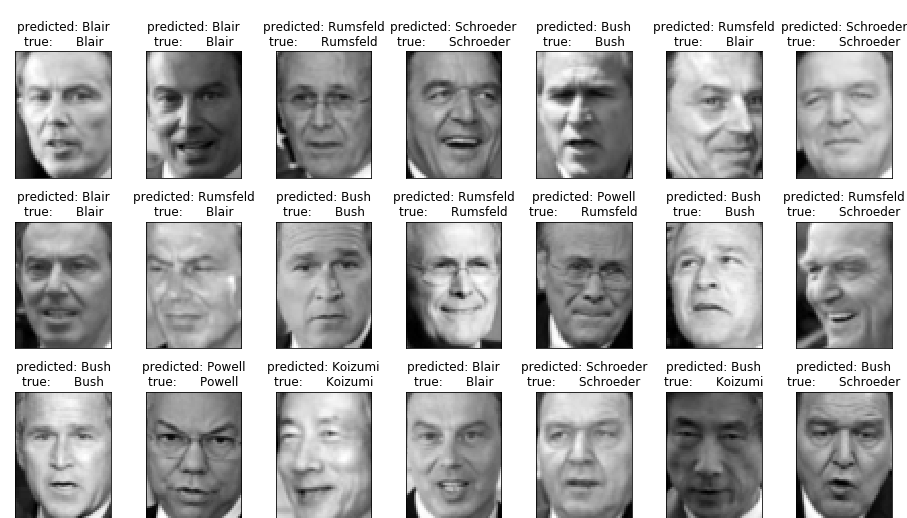

In [63]:
def make_title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [make_title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

On this small sample, our optimal estimator mislabeled a few faces.
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [64]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.69      0.81        16
     Colin Powell       0.85      0.87      0.86        61
  Donald Rumsfeld       0.75      0.69      0.72        35
    George W Bush       0.78      0.97      0.86       125
Gerhard Schroeder       0.86      0.66      0.75        29
      Hugo Chavez       1.00      0.68      0.81        19
Junichiro Koizumi       1.00      0.76      0.87        17
       Tony Blair       0.93      0.77      0.84        35

         accuracy                           0.83       337
        macro avg       0.90      0.76      0.82       337
     weighted avg       0.85      0.83      0.83       337



In [65]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[ 11   3   1   1   0   0   0   0]
 [  0  53   1   7   0   0   0   0]
 [  0   2  24   7   1   0   0   1]
 [  0   2   2 121   0   0   0   0]
 [  0   0   1   8  19   0   0   1]
 [  0   1   0   4   1  13   0   0]
 [  0   0   0   4   0   0  13   0]
 [  0   1   3   3   1   0   0  27]]


We might also display the confusion matrix between these classes:

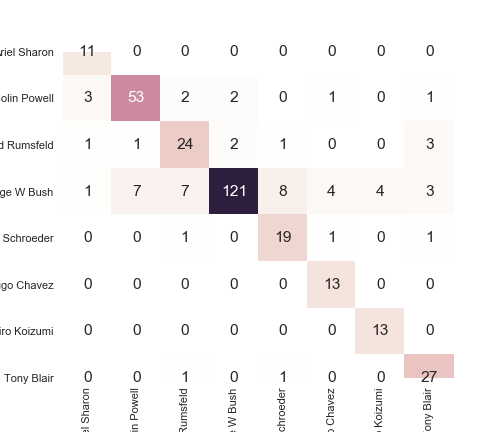

In [66]:
from sklearn.metrics import confusion_matrix

# use seaborn plotting defaults
import seaborn as sns; sns.set()

mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7,6))
sns.set(font_scale=1.3)
sns.heatmap(mat.T, square=False, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names,
            cmap=sns.cubehelix_palette(light=1, as_cmap=True))

plt.xlabel('true label');
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.

## Exercise: Face Recognition

In the previous example we have chosen a number of principal components by hand.
In order to find suitable parameters for the SVM, we have applied a grid search in which for each set of parameter values we have ran a cross-validation procedure to determine the fitness of the parameters.
In this exercise you will extend the gird search to the number of principal components, using the [Pipeline class](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) from scikit-learn.

1. Build a classifier that consists of a pipeline of PCA and the support vector classifier.
2. Define a grid containing the values to consider for each of the parametres:
  - 3 values for PCA's `n_components`
  - 3 values for SVC's `C`
  - 3 values for SVC's `gamma`
3. Use GridSearchCV to find the best set of values for these 3 parameters.
4. Apply the classifier with the best parameters to the test set and plot the `classification_report` and the `confusion_matrix`.

In [67]:
# 1. Pipeline
from sklearn.pipeline import Pipeline

pca = PCA(whiten=True,svd_solver='randomized', random_state=0)
clf = SVC(kernel = "rbf",class_weight = 'balanced')

the_pipe = Pipeline([('pca',pca),('svm',clf)])

In [71]:
# 2. Define grid for GridsearchCV
param_grid = {'pca__n_components':[50,100,150],'svm__C': [1E2, 5E2, 1E3],'svm__gamma': [0.0001,0.001,0.1]}

In [77]:
# 3. Run GridSearchCV
t0 = time()
print("Fitting the classifier to the training set...")

grid = GridSearchCV(the_pipe, param_grid, cv=3)
grid.fit(X_train, y_train)
clf = grid.best_estimator_

print("Elapsed time: %0.3fs"%(time() - t0))
print("Best estimator found by grid search:")
print(grid.best_params_)

Fitting the classifier to the training set...
Elapsed time: 45.544s
Best estimator found by grid search:
{'pca__n_components': 50, 'svm__C': 100.0, 'svm__gamma': 0.001}


In [78]:
# 4. Test the classifier
print("Predicting people's names on the test set...")

y_pred = clf.predict(X_test)

print("Done.")

Predicting people's names on the test set...
Done.


In [79]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[  7   4   3   0   2   0   0   0]
 [  2  53   1   3   1   0   0   1]
 [  1   1  27   1   5   0   0   0]
 [  0   2   8 108   3   1   0   3]
 [  1   0   1   3  18   1   2   3]
 [  1   2   0   0   4  11   0   1]
 [  0   0   0   2   0   1  13   1]
 [  4   1   2   2   6   0   0  20]]


In [80]:
print(classification_report(y_test, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.44      0.44      0.44        16
     Colin Powell       0.84      0.87      0.85        61
  Donald Rumsfeld       0.64      0.77      0.70        35
    George W Bush       0.91      0.86      0.89       125
Gerhard Schroeder       0.46      0.62      0.53        29
      Hugo Chavez       0.79      0.58      0.67        19
Junichiro Koizumi       0.87      0.76      0.81        17
       Tony Blair       0.69      0.57      0.62        35

         accuracy                           0.76       337
        macro avg       0.70      0.68      0.69       337
     weighted avg       0.78      0.76      0.77       337



## Support Vector Machine Summary

We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

With those traits in mind, SVMs are advisable once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

### References

- [Python Data Science Handbook by Jake VanderPlas](https://github.com/jakevdp/PythonDataScienceHandbook). MIT License.
- [scikit-learn Examples](http://scikit-learn.org/stable/auto_examples/). BSD License.
